## Problem definition

The main equation: $\nabla \cdot (-\sigma\nabla{V}) = 0$

Where both $\sigma(x)$ and $V(x)$ vary with position.

We assume Dirichlet boundary conditions: $V(0) = 0$ and $V(1) = 10$

Further, $\sigma$ is defined as:
$$
\sigma(x)=
\begin{cases}
1 & \quad \text{when $x<0.5$}\\
2 & \quad \text{otherwise}
\end{cases}
$$

To solve this analytically we need to devide the diffrential equation in two parts, one for $x<0.5$ and another for $x\geq0.5$. The double integration after using the boundary condition yields the result:
$$
V(x)=
\begin{cases}
\frac{40}{3}x & \quad \text{when $x<0.5$}\\
\frac{20}{3}x + \frac{10}{3} & \quad \text{otherwise}
\end{cases}
$$

## Solution using `skfem`

In [1]:
import skfem
import skfem.visuals.matplotlib
from skfem.helpers import grad, dot
import numpy as np

In [2]:
np.linspace(0, 1, num=100).shape

(100,)

In [3]:
mesh = skfem.MeshLine(p=np.linspace(0, 1, num=100))

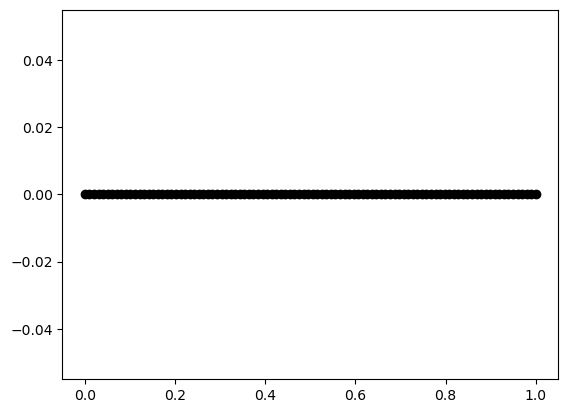

In [4]:
skfem.visuals.matplotlib.draw(mesh);

In [5]:
basis_p1 = skfem.Basis(mesh=mesh, elem=skfem.ElementLineP1())
basis_p0 = skfem.Basis(mesh=mesh, elem=skfem.ElementDG(skfem.ElementLineP0()))

In [6]:
basis_p0

<skfem CellBasis(MeshLine1, ElementDG) object>
  Number of elements: 99
  Number of DOFs: 99
  Size: 3168 B

In [7]:
basis_p1

<skfem CellBasis(MeshLine1, ElementLineP1) object>
  Number of elements: 99
  Number of DOFs: 100
  Size: 6336 B

In [8]:
sigma = np.squeeze(np.where(basis_p0.doflocs < 0.5, 1., 2.))

In [9]:
sigma.shape

(99,)

In [10]:
sigma_field = basis_p0.interpolate(sigma)

In [11]:
@skfem.BilinearForm
def stifness_matrix(u, v, w):
    return - w.sigma * dot(grad(u), grad(v))

In [12]:
@skfem.LinearForm
def l(v, _):
    return 0 * v

In [13]:
S = stifness_matrix.assemble(basis_p1, sigma=sigma_field)

In [14]:
S

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 298 stored elements and shape (100, 100)>

In [15]:
L = l.assemble(basis_p1)

In [16]:
L

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
boundary_nodes = basis_p1.get_dofs().flatten()

In [18]:
pot = basis_p1.zeros()
pot[boundary_nodes[0]] = 0.
pot[boundary_nodes[1]] = 10.

In [19]:
pot = skfem.solve(*skfem.condense(S, L, x=pot, D=basis_p1.get_dofs()))

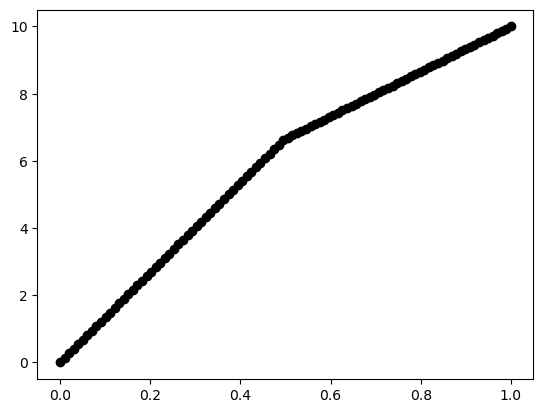

In [20]:
skfem.visuals.matplotlib.plot(mesh, pot);

## Comparing both solutions

In [21]:
analytical_pot = np.where(mesh.p[0]<0.5, mesh.p[0] * 40 / 3, (mesh.p[0] * 20 / 3) + (10/3))

In [22]:
np.linalg.norm(analytical_pot - pot)

np.float64(0.10228026668754402)

In [23]:
import matplotlib.pyplot as plt

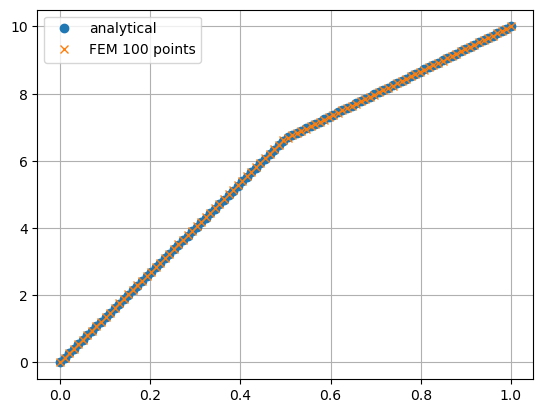

In [24]:
plt.plot(mesh.p[0], analytical_pot, "o", label="analytical")
plt.plot(mesh.p[0], pot, "x", label="FEM 100 points")
plt.legend()
plt.grid()
plt.show()

## Stiffness matrix

In [36]:
S.toarray()

array([[ -99.,   99.,    0., ...,    0.,    0.,    0.],
       [  99., -198.,   99., ...,    0.,    0.,    0.],
       [   0.,   99., -198., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ..., -396.,  198.,    0.],
       [   0.,    0.,    0., ...,  198., -396.,  198.],
       [   0.,    0.,    0., ...,    0.,  198., -198.]], shape=(100, 100))